<a href="https://colab.research.google.com/github/nmningmei/simple_tensorflow_logistic_regression_classifier/blob/main/simple_logistic_regression_implemented_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
if not os.path.exists("/content/simple_tensorflow_logistic_regression_classifier"):
    !git clone https://github.com/nmningmei/simple_tensorflow_logistic_regression_classifier.git

os.chdir("/content/simple_tensorflow_logistic_regression_classifier")

In [67]:
ls

LICENSE                                                     temp.h5
__pycache__/                                                test.py
README.md                                                   utils.py
simple_logistic_regression_implemented_in_tensorflow.ipynb


In [68]:
import numpy as np
import tensorflow as tf
from utils import (build_logistic_regression,
                   compile_logistic_regression)
from tensorflow.keras import regularizers
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

# experiment control

In [69]:
n_epochs = int(1e3) # just a large number
print_train = True

# clear memory states

In [70]:
tf.keras.backend.clear_session()

# generate random test data

In [71]:
X,y = make_classification(n_samples             = 500,
                         n_features            = 100,
                         n_informative         = 3,
                         n_redundant           = 10,
                         n_classes             = 2,
                         n_clusters_per_class  = 4,
                         flip_y                = .01,
                         class_sep             = .5,# how easy to separate the two classes
                         shuffle               = True,
                         random_state          = 12345,
                         )

# one-hot encoding for softmax

In [72]:
y = y.reshape((-1,1))
y = np.hstack([y,1-y])

# split the data into train, validation, and test

In [73]:
X_train,X_test,y_train,y_test   = train_test_split(X,y,test_size = .1,random_state = 12345)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size = .1,random_state = 12345)
# add some 0.5 labeled data - don't use too much
X_noise = np.random.normal(X_train.mean(),X_train.std(),size = (int(X_train.shape[0]/8),100))
y_noise = np.array([[0.5,0.5]] * int(X_train.shape[0]/8))
X_train = np.concatenate([X_train,X_noise])
y_train = np.concatenate([y_train,y_noise])

X_noise = np.random.normal(X_test.mean(),X_test.std(),size = (int(X_test.shape[0]/2),100))
y_noise = np.array([[0.5,0.5]] * int(X_test.shape[0]/2))
X_test  = np.concatenate([X_test,X_noise])
y_test  = np.concatenate([y_test,y_noise])

# build the model

In [74]:
tf.random.set_seed(12345)
logistic_regression = build_logistic_regression(
                        input_size              = X_train.shape[1],
                        output_size             = 2,
                        special                 = False,
                        kernel_regularizer      = regularizers.L2(l2 = 1e-2),
                        activity_regularizer    = regularizers.L1(l1 = 1e-32), # this makes the prediction sparse
                        print_model             = True,
                        )

Model: "logistic_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 logistic_layer (Dense)      (None, 2)                 202       
                                                                 
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________
None


# compile the model

In [75]:
from tensorflow.keras import metrics
logistic_regression,callbacks = compile_logistic_regression(
                                logistic_regression,
                                model_name      = 'temp.h5',
                                optimizer       = None,
                                loss_function   = None,
                                metric          = metrics.mean_absolute_error,
                                callbacks       = None,
                                learning_rate   = 1e-3,
                                tol             = 1e-4,
                                patience        = 50, # this would make the training take more time
                                )

# train and validate the model

In [76]:
logistic_regression.fit(
                        X_train,
                        y_train,
                        batch_size      = 4,
                        epochs          = n_epochs,
                        verbose         = print_train,
                        callbacks       = callbacks,
                        validation_data = (X_valid,y_valid),
                        shuffle         = True,
                        #class_weight    = {0:1,1:2},# tf has this but I don't think it is the same as sklearn
                        )
y_pred = logistic_regression.predict(X_test)

Epoch 1/1000
114/114 [==============================] - 1s 5ms/step - loss: 0.9732 - mean_absolute_error: 0.5261 - val_loss: 0.9585 - val_mean_absolute_error: 0.5632
Epoch 2/1000
114/114 [==============================] - 0s 3ms/step - loss: 0.9508 - mean_absolute_error: 0.5168 - val_loss: 0.9390 - val_mean_absolute_error: 0.5546
Epoch 3/1000
114/114 [==============================] - 0s 3ms/step - loss: 0.9298 - mean_absolute_error: 0.5076 - val_loss: 0.9208 - val_mean_absolute_error: 0.5458
Epoch 4/1000
114/114 [==============================] - 0s 2ms/step - loss: 0.9101 - mean_absolute_error: 0.4983 - val_loss: 0.9034 - val_mean_absolute_error: 0.5369
Epoch 5/1000
114/114 [==============================] - 0s 2ms/step - loss: 0.8916 - mean_absolute_error: 0.4895 - val_loss: 0.8873 - val_mean_absolute_error: 0.5281
Epoch 6/1000
114/114 [==============================] - 0s 2ms/step - loss: 0.8744 - mean_absolute_error: 0.4809 - val_loss: 0.8722 - val_mean_absolute_error: 0.5193
Epoc

In [77]:
_idx, = np.where(y_test[:,-1] != 0.5)
print(f'test score = {roc_auc_score(y_test[_idx],y_pred[_idx],):.4f}')

test score = 0.7101


# visualize the distribution of the predictions

In [78]:
print(y_test)
print(y_pred)

[[1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [1.  0. ]
 [0.  1. ]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[0.9917195  0.00828051]
 [0.02096721 0.9790329 ]
 [0.7014006  0.29859945]
 [0.7677439  0.2322561 ]
 [0.9974952  0.00250483]
 [0.37727454 0.6227254 ]
 [0.9334753  0.0665247 ]

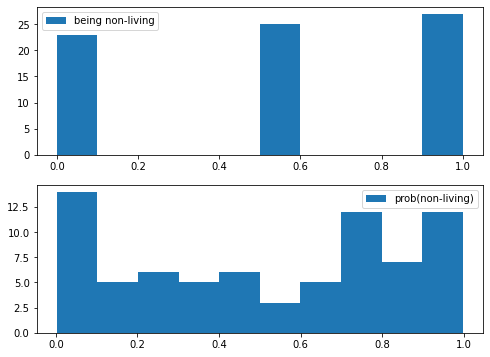

In [79]:
fig,axes = plt.subplots(figsize = (8,6),
                        nrows = 2,
                        )
ax = axes.flatten()[0]
ax.hist(y_test[:,-1],label = 'being non-living')
ax.legend()
ax = axes.flatten()[1]
ax.hist(y_pred[:,-1],label = 'prob(non-living)')
ax.legend()